# Libraries used

Running Kernel3.9.13 base anaconda

pip install squarify
pip install yellowbrick
pip install plotly
pip install seaborn
pip install lazypredict
pip install pandas_profiling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
import plotly.io as pio
import os
import matplotlib
import warnings

from imblearn.over_sampling import SMOTE


#to enable the inline plotting
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

In [2]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#rfc using regularization and gridsearch to find the best parameters for the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import normaltest

from pandas_profiling import ProfileReport

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

import lazypredict
from lazypredict.Supervised import LazyClassifier


warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Function for EDA. Using the display() function to have  well-formatted tables. We are mainly using pandas to explore the datasets

def dataset_description(df_target):

    print('This is the Dataset shape: %s\n' % (df_target.shape, ))
    print('Dataset columns: %s\n' % df_target.columns)

    print('\nColumns description:\n')
    display(df_target.info())
    display(df_target.describe())  # describe the dataset

    print('\nNull values:\n')
    display(df_target.isnull().sum())  # Identify null values

#function performing a quick check on df_inspection to have best of pandas functions separated by a line
def quick_check(dataframe):
    print('First 5 rows %s\n')
    print(dataframe.head(2))
    print("=====================================")
    print('Dataframe shape %s\n')
    print(dataframe.shape)
    print("=====================================")
    print('Dataframe describe categorical %s\n')
    print(dataframe.describe(include=['O']))
    print("=====================================")
    print('Dataframe null values %s\n')
    print(dataframe.isnull().sum())
    print("=====================================")
    print('Dataframe value counts %s\n')
    print(dataframe.value_counts())
    print("=====================================")

#stats function
def stats(dataframe):
    print('Dataframe correlation %s\n')
    print(dataframe.corr())
    print("=====================================")
    print('Dataframe covariance %s\n')
    print(dataframe.cov())
    print("=====================================")
    print('Dataframe skew %s\n')
    print(dataframe.skew())
    print("=====================================")
    print('Dataframe kurtosis %s\n')
    print(dataframe.kurt())
    print("=====================================")

#create a function to normalize characters from a dataset's column in Spanish
def normalize_characters(df, column):
    df[column] = df[column].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace('á', 'a')
    df[column] = df[column].str.replace('é', 'e')
    df[column] = df[column].str.replace('í', 'i')
    df[column] = df[column].str.replace('ó', 'o')
    df[column] = df[column].str.replace('ú', 'u')
    df[column] = df[column].str.replace('ñ', 'n')
    df[column] = df[column].str.replace('ü', 'u')
    df[column] = df[column].str.replace('ç', 'c')
    df[column] = df[column].str.replace('(', '')
    df[column] = df[column].str.replace(')', '')
    df[column] = df[column].str.replace('\'', '')
    df[column] = df[column].str.replace('´', '')
    df[column] = df[column].str.replace('`', '')
    df[column] = df[column].str.replace('’', '')
    return df.head(2)

#create function to change detypes in64 to int32 in a df
def change_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    return df.head(2)

def outlier_function(df, col_name):
    """ this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively"""
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                        
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                    
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
        else:
            pass
    return lower_limit, upper_limit, outlier_count

In [4]:
#show all print outputs when using a function
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#display all columns
pd.set_option('display.max_columns', None)


# Importing previous dataset with outliers

In [5]:
#point to the folder where the data is stored
os.chdir(r"C:\Users\pedro\datathon")

# Loading combined_mod dataset
train_consolidated = pd.read_csv('train_consolidated_with_outliers_and_pop.csv')
sample_submission = pd.read_csv('submission_for_outliers_220223_with_pop.csv')

In [6]:
#put the same order for the columns in train_consolidated and sample_submission
train_consolidated = train_consolidated[sample_submission.columns]


In [7]:
#check nulls in sample_submission 
sample_submission.isnull().sum()


PipeId                                          0
Incidence                                       0
Province                                        0
Town                                            0
YearBuilt                                       0
Diameter                                        0
Length                                          0
Pressure                                        0
NumConnections                                  0
NumConnectionsUnder                             0
BoolBridle                                      0
aspect                                          0
Relative_Thickness                              0
pipe_area                                       0
Total_Connections                               0
area_connection                                 0
connection_bool                                 0
gas_natural                                     0
Material_Acrylonitrile-Butadiene-Styrene        0
Material_Copper                                 0


## Filling Nulls in sample submission file

In [8]:
#fill the nulls in No_Inspectio with 1
sample_submission['No_Inspections'].fillna(1, inplace=True)


In [9]:
#fill the nulls in average_severity_pipe  with the mean of the column
sample_submission['average_severity_pipe'].fillna(sample_submission['average_severity_pipe'].mean(), inplace=True)

In [10]:
#fill nulls in relative_risk by multyplying No_Incidences by  average_severity_pipe
sample_submission['relative_risk'] = sample_submission['No_Previous_Incidences'] * sample_submission['average_severity_pipe']

In [11]:
#fill nulls in preventive_maintenance_rate by dividing relative_risk by No_Inspections
sample_submission['preventive_maintenance_rate'] = sample_submission['relative_risk'] / sample_submission['No_Inspections']

In [12]:
#fill the nulls in Probability_rate with No_Previous_Incidences divided by No_Inspections
sample_submission['Probability_rate'] = sample_submission['No_Previous_Incidences'] / sample_submission['No_Inspections']


## Dtypes in sample submission file

In [13]:
sample_submission.dtypes

PipeId                                        int64
Incidence                                     int64
Province                                     object
Town                                         object
YearBuilt                                   float64
Diameter                                    float64
Length                                      float64
Pressure                                    float64
NumConnections                                int64
NumConnectionsUnder                           int64
BoolBridle                                    int64
aspect                                      float64
Relative_Thickness                          float64
pipe_area                                   float64
Total_Connections                             int64
area_connection                             float64
connection_bool                               int64
gas_natural                                   int64
Material_Acrylonitrile-Butadiene-Styrene      int64
Material_Cop

In [14]:
#drop Province, Town from sample_submission
sample_submission.drop(['Province', 'Town','Area (sq km)', 'Population'], axis=1, inplace=True)

## Standarizing data in sample submission

In [15]:
sample_submission.head(1)

,PipeId,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,Total_Connections,area_connection,connection_bool,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Diameter2,Length2,Pressure2,Average yearly temperature (°C),Min. Temperature (°C),Max. Temperature (°C),Yearly Rainfall (mm),Average year Humidity (%),Rainy days per year (days),Yearly Sun Hours (hours),No_Inspections,average_severity_pipe,Average_MonthsLastRev,pipe_inspected_frequently,No_Previous_Incidences,No_Previous_Severity_High,No_Previous_Severity_Medium,No_Previous_Severity_Low,InspectionYear,MonthsLastRev,relative_risk,preventive_maintenance_rate,Probability_rate,Age_pipe_at_inspection,Population density (persons/sqkm)
0,446859944,0,2012.00,0.11,44.29,0.15,0,0,0,60.39,0.73,15.30,0,0.00,0,1,0,0,0,1,0,0.01,1961.25,0.02,17.62,6.60,30.80,427,0.64,46,113.20,5.00,4.00,20.75,1.00,0.00,0.00,0.00,0.00,2021.00,24.00,0.00,0.00,0.00,9.00,239.60


In [16]:
sample_submission.columns

Index(['PipeId', 'Incidence', 'YearBuilt', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle', 'aspect',
       'Relative_Thickness', 'pipe_area', 'Total_Connections',
       'area_connection', 'connection_bool', 'gas_natural',
       'Material_Acrylonitrile-Butadiene-Styrene', 'Material_Copper',
       'Material_Fiberglass-Reinforced Plastic', 'Material_Polyethylene',
       'Material_Polypropylene', 'Diameter2', 'Length2', 'Pressure2',
       'Average yearly temperature (°C)', 'Min. Temperature (°C)',
       'Max. Temperature (°C)', 'Yearly Rainfall (mm)',
       'Average year Humidity (%)', 'Rainy days per year (days)',
       'Yearly Sun Hours (hours)', 'No_Inspections', 'average_severity_pipe',
       'Average_MonthsLastRev', 'pipe_inspected_frequently',
       'No_Previous_Incidences', 'No_Previous_Severity_High',
       'No_Previous_Severity_Medium', 'No_Previous_Severity_Low',
       'InspectionYear', 'MonthsLastRev', 'relative_risk',

In [17]:
#import min max scaler
from sklearn.preprocessing import MinMaxScaler


In [18]:
#Use minmax scaler to scale these columns in sample_submission: 
# 'YearBuilt', 'Diameter','Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'aspect', 'Relative_Thickness', 'pipe_area', 'Total_Connections', 'area_connection', 'Diameter2', 'Length2', 'Pressure2', 'Average yearly temperature (°C)', 'Min. Temperature (°C)', 'Max. Temperature (°C)', 'Yearly Rainfall (mm)', 'Average year Humidity (%)', 'Rainy days per year (days)', 'Yearly Sun Hours (hours)','No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
#       'No_Previous_Incidences', 'relative_risk', 'preventive_maintenance_rate',
#       'Probability_rate', 'No_Inspections', 'average_severity_pipe',
#       'relative_risk', 'preventive_maintenance_rate', 'Probability_rate'

scaler = MinMaxScaler()

sample_submission[['YearBuilt', 'Diameter','Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'aspect', 'Relative_Thickness', 'pipe_area', 'Total_Connections', 'area_connection', 'Diameter2', 'Length2', 'Pressure2', 'Average yearly temperature (°C)', 'Min. Temperature (°C)', 'Max. Temperature (°C)', 'Yearly Rainfall (mm)', 'Average year Humidity (%)', 'Rainy days per year (days)', 'Yearly Sun Hours (hours)','No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
       'No_Previous_Incidences', 'relative_risk', 'preventive_maintenance_rate',
       'Probability_rate', 'No_Inspections', 'average_severity_pipe',
       'relative_risk', 'preventive_maintenance_rate', 'Probability_rate', 'InspectionYear',  'MonthsLastRev','Age_pipe_at_inspection', 'Population density (persons/sqkm)']] = scaler.fit_transform(sample_submission[['YearBuilt', 'Diameter','Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'aspect', 'Relative_Thickness', 'pipe_area', 'Total_Connections', 'area_connection', 'Diameter2', 'Length2', 'Pressure2', 'Average yearly temperature (°C)', 'Min. Temperature (°C)', 'Max. Temperature (°C)', 'Yearly Rainfall (mm)', 'Average year Humidity (%)', 'Rainy days per year (days)', 'Yearly Sun Hours (hours)','No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
       'No_Previous_Incidences', 'relative_risk', 'preventive_maintenance_rate',
       'Probability_rate', 'No_Inspections', 'average_severity_pipe',
       'relative_risk', 'preventive_maintenance_rate', 'Probability_rate', 'InspectionYear', 'MonthsLastRev','Age_pipe_at_inspection', 'Population density (persons/sqkm)']])
sample_submission.head(1)

,PipeId,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,Total_Connections,area_connection,connection_bool,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Diameter2,Length2,Pressure2,Average yearly temperature (°C),Min. Temperature (°C),Max. Temperature (°C),Yearly Rainfall (mm),Average year Humidity (%),Rainy days per year (days),Yearly Sun Hours (hours),No_Inspections,average_severity_pipe,Average_MonthsLastRev,pipe_inspected_frequently,No_Previous_Incidences,No_Previous_Severity_High,No_Previous_Severity_Medium,No_Previous_Severity_Low,InspectionYear,MonthsLastRev,relative_risk,preventive_maintenance_rate,Probability_rate,Age_pipe_at_inspection,Population density (persons/sqkm)
0,446859944,0,0.82,0.17,0.01,0.00,0.00,0.00,0,0.00,0.03,0.00,0.00,0.00,0,1,0,0,0,1,0,0.03,0.00,0.00,0.86,0.77,0.64,0.15,0.38,0.20,0.83,0.36,1.00,0.21,1.00,0.00,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.00,0.17,0.28


## Correlation matrix for sample_submission

In [19]:
#grpah correlation matrix in sample_submission
corr_matrix = sample_submission.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
to_drop


['Total_Connections', 'relative_risk', 'Age_pipe_at_inspection']

In [20]:
sample_submission.corr()['Incidence'].sort_values(ascending=False)


Incidence                                   1.00
area_connection                             0.00
Pressure                                    0.00
Pressure2                                   0.00
average_severity_pipe                       0.00
YearBuilt                                   0.00
aspect                                      0.00
Population density (persons/sqkm)           0.00
Material_Acrylonitrile-Butadiene-Styrene    0.00
PipeId                                      0.00
No_Previous_Severity_Medium                 0.00
Length                                      0.00
No_Inspections                              0.00
NumConnections                              0.00
Total_Connections                           0.00
Average year Humidity (%)                   0.00
connection_bool                             0.00
pipe_area                                   0.00
Material_Fiberglass-Reinforced Plastic      0.00
InspectionYear                              0.00
Rainy days per year 

In [21]:
#DROP Total_Connections IN sample_submission
sample_submission.drop(['Total_Connections'], axis=1, inplace=True)

<Figure size 2000x2000 with 0 Axes>

<AxesSubplot: >

Text(0.5, 1.0, 'Correlation matrix for sample_submission')

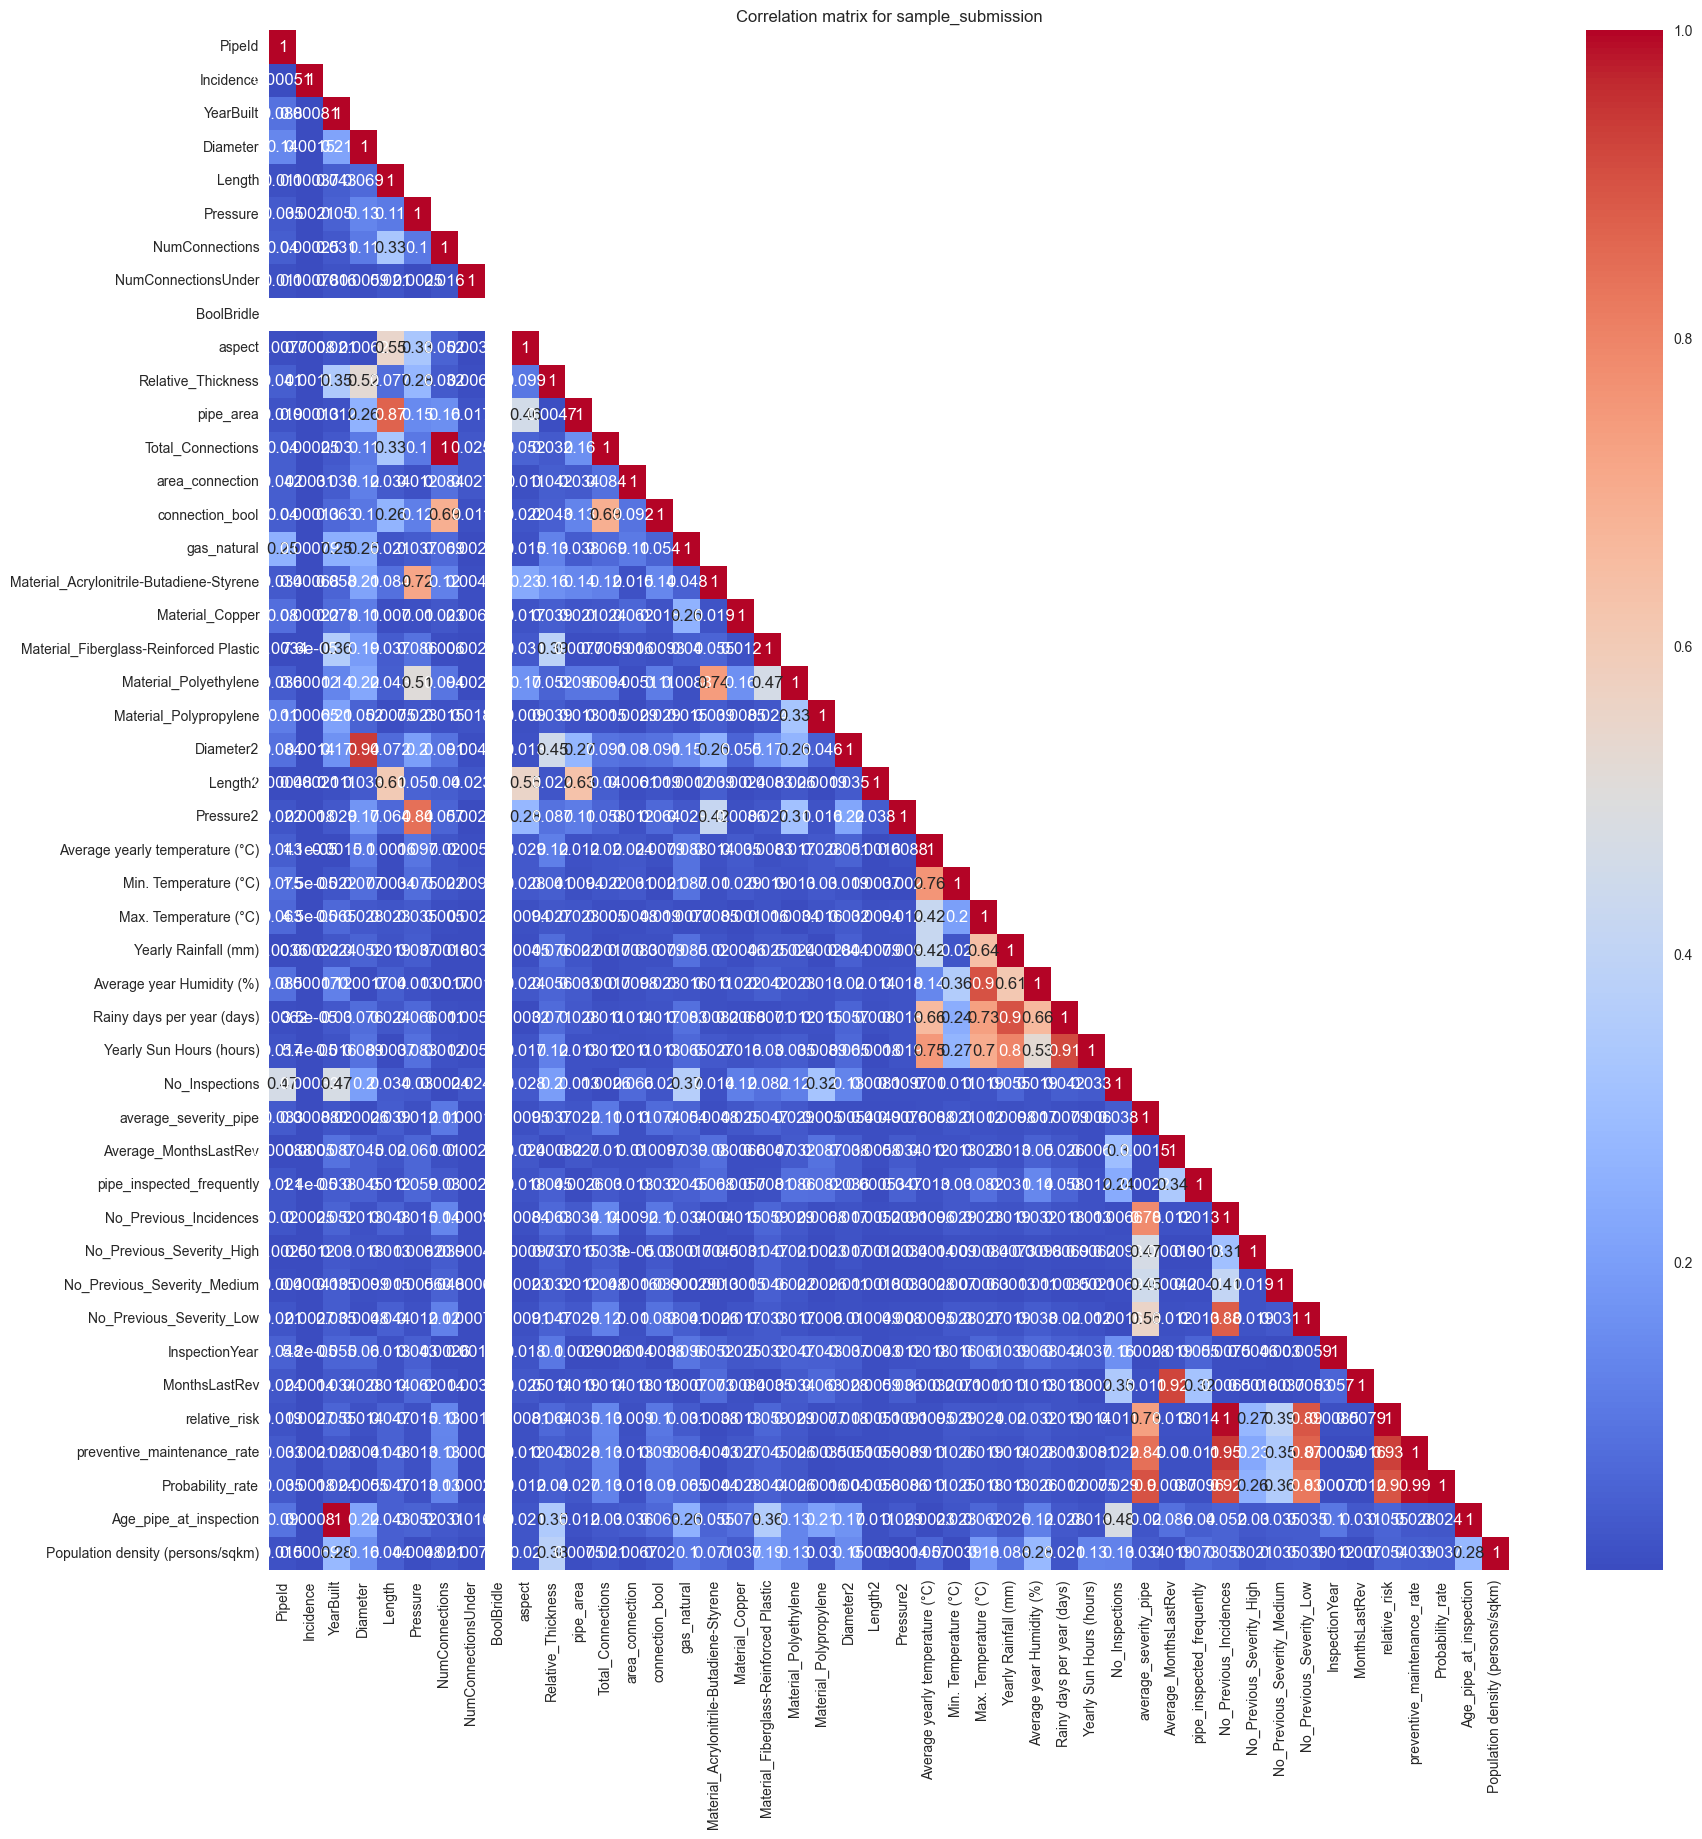

In [22]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=np.triu(corr_matrix, k=1))
plt.title('Correlation matrix for sample_submission')
plt.show()


We are not going to drop any variables as in now just for testing purposes


# Checking train file
## Nulls in train file

In [23]:
#checking nulls in train_consolidated
train_consolidated.isnull().sum()

PipeId                                      0
Incidence                                   0
Province                                    0
Town                                        0
YearBuilt                                   0
Diameter                                    0
Length                                      0
Pressure                                    0
NumConnections                              0
NumConnectionsUnder                         0
BoolBridle                                  0
aspect                                      0
Relative_Thickness                          0
pipe_area                                   0
Total_Connections                           0
area_connection                             0
connection_bool                             0
gas_natural                                 0
Material_Acrylonitrile-Butadiene-Styrene    0
Material_Copper                             0
Material_Fiberglass-Reinforced Plastic      0
Material_Polyethylene             

## Dtypes in train_consolidated

In [24]:
train_consolidated.dtypes

PipeId                                        int64
Incidence                                     int64
Province                                     object
Town                                         object
YearBuilt                                   float64
Diameter                                    float64
Length                                      float64
Pressure                                    float64
NumConnections                                int64
NumConnectionsUnder                           int64
BoolBridle                                    int64
aspect                                      float64
Relative_Thickness                          float64
pipe_area                                   float64
Total_Connections                             int64
area_connection                             float64
connection_bool                               int64
gas_natural                                   int64
Material_Acrylonitrile-Butadiene-Styrene      int64
Material_Cop

In [25]:
train_consolidated.columns

Index(['PipeId', 'Incidence', 'Province', 'Town', 'YearBuilt', 'Diameter',
       'Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder',
       'BoolBridle', 'aspect', 'Relative_Thickness', 'pipe_area',
       'Total_Connections', 'area_connection', 'connection_bool',
       'gas_natural', 'Material_Acrylonitrile-Butadiene-Styrene',
       'Material_Copper', 'Material_Fiberglass-Reinforced Plastic',
       'Material_Polyethylene', 'Material_Polypropylene', 'Diameter2',
       'Length2', 'Pressure2', 'Average yearly temperature (°C)',
       'Min. Temperature (°C)', 'Max. Temperature (°C)',
       'Yearly Rainfall (mm)', 'Average year Humidity (%)',
       'Rainy days per year (days)', 'Yearly Sun Hours (hours)',
       'No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
       'pipe_inspected_frequently', 'No_Previous_Incidences',
       'No_Previous_Severity_High', 'No_Previous_Severity_Medium',
       'No_Previous_Severity_Low', 'InspectionYear', 'MonthsLastRe

In [26]:
#drop 'MaintenanceId', InspectionDate, Province, Province, 'Severity_high', 'Severity_medium', 'Severity_low'
train_consolidated.drop(['Province', 'Town', 'Area (sq km)', 'Population'], axis=1, inplace=True)

In [27]:
#difference in columns between train_consolidated and sample_submission
set(train_consolidated.columns) - set(sample_submission.columns)


{'Total_Connections'}

## Standarizing

In [28]:
scaler = MinMaxScaler()

train_consolidated[['YearBuilt', 'Diameter','Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'aspect', 'Relative_Thickness', 'pipe_area', 'Total_Connections', 'area_connection', 'Diameter2', 'Length2', 'Pressure2', 'Average yearly temperature (°C)', 'Min. Temperature (°C)', 'Max. Temperature (°C)', 'Yearly Rainfall (mm)', 'Average year Humidity (%)', 'Rainy days per year (days)', 'Yearly Sun Hours (hours)','No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
       'No_Previous_Incidences', 'relative_risk', 'preventive_maintenance_rate',
       'Probability_rate', 'No_Inspections', 'average_severity_pipe',
       'relative_risk', 'preventive_maintenance_rate', 'Probability_rate', 'InspectionYear',  'MonthsLastRev','Age_pipe_at_inspection', 'Population density (persons/sqkm)']] = scaler.fit_transform(train_consolidated[['YearBuilt', 'Diameter','Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'aspect', 'Relative_Thickness', 'pipe_area', 'Total_Connections', 'area_connection', 'Diameter2', 'Length2', 'Pressure2', 'Average yearly temperature (°C)', 'Min. Temperature (°C)', 'Max. Temperature (°C)', 'Yearly Rainfall (mm)', 'Average year Humidity (%)', 'Rainy days per year (days)', 'Yearly Sun Hours (hours)','No_Inspections', 'average_severity_pipe', 'Average_MonthsLastRev',
       'No_Previous_Incidences', 'relative_risk', 'preventive_maintenance_rate',
       'Probability_rate', 'No_Inspections', 'average_severity_pipe',
       'relative_risk', 'preventive_maintenance_rate', 'Probability_rate', 'InspectionYear', 'MonthsLastRev','Age_pipe_at_inspection', 'Population density (persons/sqkm)']])
train_consolidated.head(1)

,PipeId,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,Total_Connections,area_connection,connection_bool,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Diameter2,Length2,Pressure2,Average yearly temperature (°C),Min. Temperature (°C),Max. Temperature (°C),Yearly Rainfall (mm),Average year Humidity (%),Rainy days per year (days),Yearly Sun Hours (hours),No_Inspections,average_severity_pipe,Average_MonthsLastRev,pipe_inspected_frequently,No_Previous_Incidences,No_Previous_Severity_High,No_Previous_Severity_Medium,No_Previous_Severity_Low,InspectionYear,MonthsLastRev,relative_risk,preventive_maintenance_rate,Probability_rate,Age_pipe_at_inspection,Population density (persons/sqkm)
0,489616,0,0.84,0.09,0.00,0.00,0.00,0.00,0,0.00,0.01,0.00,0.00,0.00,0,1,0,0,0,1,0,0.01,0.00,0.00,0.59,0.26,0.86,0.16,0.00,0.28,0.71,0.00,1.00,0.16,1,0.00,0,0,0,0.30,0.12,0.00,0.00,0.00,0.02,0.02


In [29]:
#creating a subset for altering the dataset after initial EDA
df_baseline = train_consolidated.copy()


In [30]:
df_baseline.head(1)

,PipeId,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,Total_Connections,area_connection,connection_bool,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Diameter2,Length2,Pressure2,Average yearly temperature (°C),Min. Temperature (°C),Max. Temperature (°C),Yearly Rainfall (mm),Average year Humidity (%),Rainy days per year (days),Yearly Sun Hours (hours),No_Inspections,average_severity_pipe,Average_MonthsLastRev,pipe_inspected_frequently,No_Previous_Incidences,No_Previous_Severity_High,No_Previous_Severity_Medium,No_Previous_Severity_Low,InspectionYear,MonthsLastRev,relative_risk,preventive_maintenance_rate,Probability_rate,Age_pipe_at_inspection,Population density (persons/sqkm)
0,489616,0,0.84,0.09,0.00,0.00,0.00,0.00,0,0.00,0.01,0.00,0.00,0.00,0,1,0,0,0,1,0,0.01,0.00,0.00,0.59,0.26,0.86,0.16,0.00,0.28,0.71,0.00,1.00,0.16,1,0.00,0,0,0,0.30,0.12,0.00,0.00,0.00,0.02,0.02


In [31]:
#count values for Incidence
df_baseline['Incidence'].value_counts()


0    6331567
1      12325
Name: Incidence, dtype: int64

# Correlation in df_baseline

In [32]:
# Correlation matrix for df_baseline
corr_matrix = df_baseline.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
to_drop


['Total_Connections', 'relative_risk', 'Probability_rate']

In [33]:
#correlation numbers with target Incidence for Total_Connections', 'relative_risk', 'Probability_rate
df_baseline.corr()['Incidence'].sort_values(ascending=False)


Incidence                                   1.00
NumConnections                              0.07
Total_Connections                           0.07
Probability_rate                            0.05
No_Previous_Incidences                      0.05
connection_bool                             0.05
preventive_maintenance_rate                 0.05
No_Previous_Severity_Low                    0.05
relative_risk                               0.05
Material_Copper                             0.03
Population density (persons/sqkm)           0.03
Material_Fiberglass-Reinforced Plastic      0.03
Length                                      0.02
Relative_Thickness                          0.02
Age_pipe_at_inspection                      0.02
pipe_area                                   0.01
Max. Temperature (°C)                       0.01
No_Previous_Severity_Medium                 0.01
No_Previous_Severity_High                   0.01
Yearly Sun Hours (hours)                    0.01
area_connection     

In [34]:
#drop Total_Connections IN df_baseline
df_baseline.drop(['Total_Connections'], axis=1, inplace=True)


<Figure size 2000x2000 with 0 Axes>

<AxesSubplot: >

Text(0.5, 1.0, 'Correlation matrix for df_baseline')

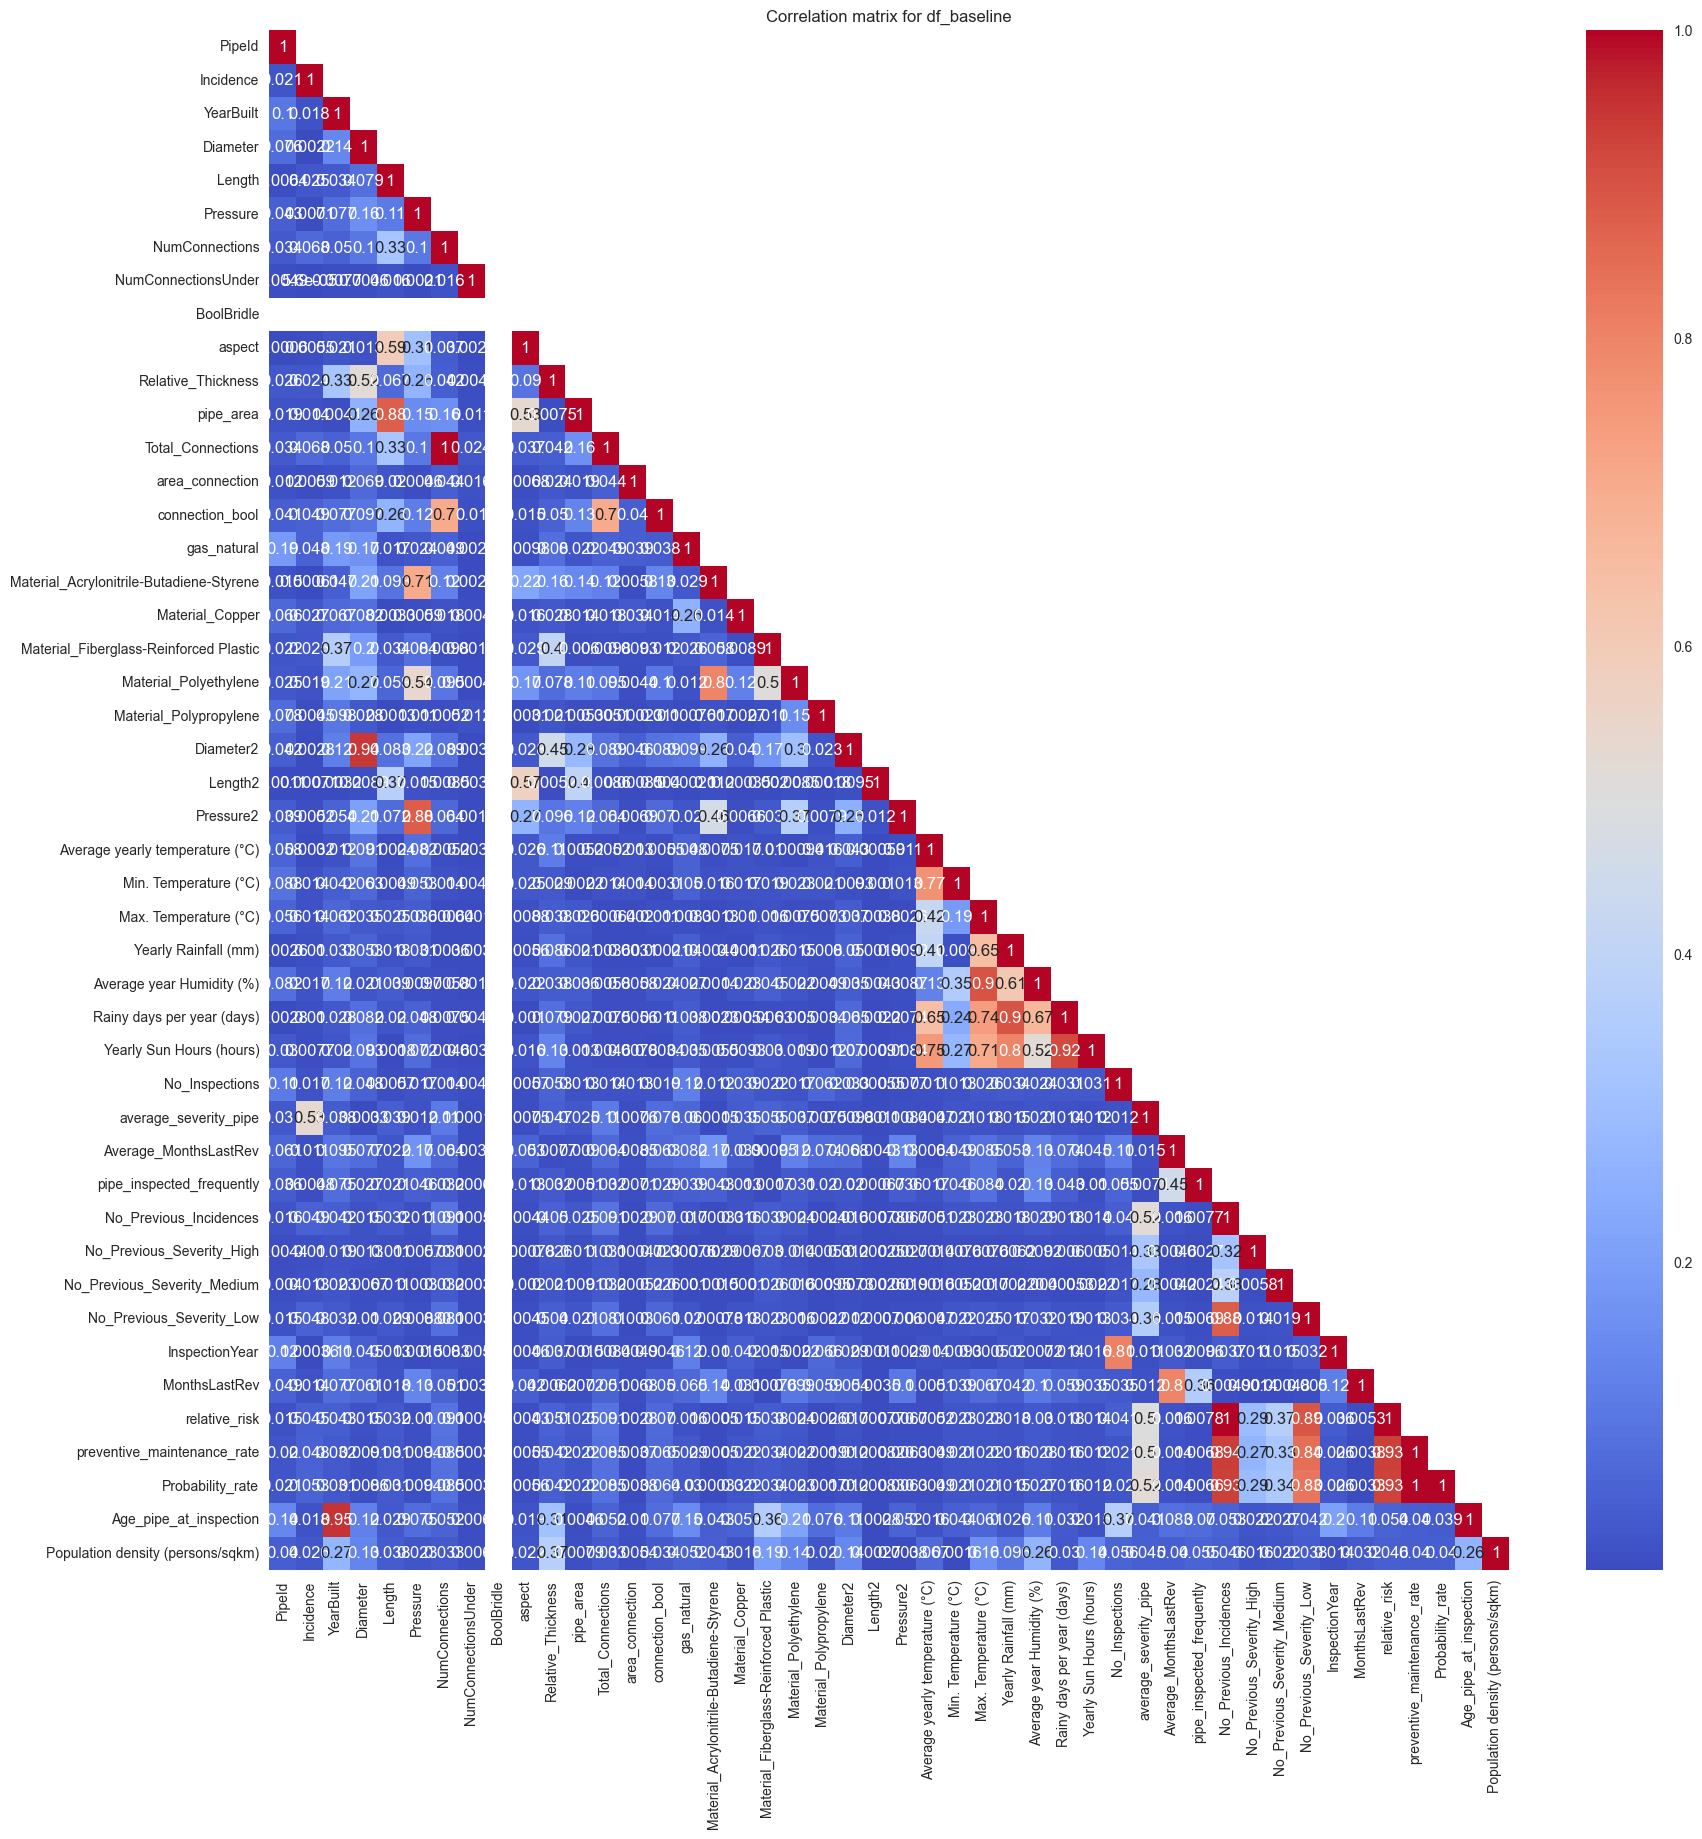

In [35]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=np.triu(corr_matrix, k=1))
plt.title('Correlation matrix for df_baseline')
plt.show()

# Approach 0: Running model with all df (best score no split)

In [36]:
#rename df_baseline as x
X = df_baseline.drop('Incidence', axis=1)
y = df_baseline['Incidence']
X_test = sample_submission.drop('Incidence', axis=1)
y_test = sample_submission['Incidence'] 

# Approach 1: Stratifying with undersampling


#undersampling the dataset
df_baseline_undersampling = df_baseline.groupby('Incidence').apply(lambda x: x.sample(df_baseline['Incidence'].value_counts().min(), random_state=42)).reset_index(drop=True)

df_baseline_undersampling['Incidence'].value_counts()


In [37]:
del train_consolidated

# Approach 2 : SMOTE to tackle the unbalanced dataset problem

#using SMOTE to balance the dataset creating a subset dataset with target y = 'Incidence' and removing Incidence','MonthsLastRev','InspectionDay','PipeId', 'MaintenanceId', 'InspectionYear', 'InspectionDate',  'Province', 'Town', 'YearBuilt' for x
X = df_baseline.drop(['PipeId','Province', 'Town'], axis=1)
y = df_baseline['Incidence']
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
X_res.shape,y_res.shape

#create a pandas dataframe with the new balanced dataset
df_baseline_balanced = pd.DataFrame(X_res, columns=X.columns)
df_baseline_balanced['Incidence'] = y_res
df_baseline_balanced.head()


#using SMOTE to balance the dataset creating a subset dataset with target y = 'Incidence'
X = df_baseline.drop('Incidence', axis=1)
y = df_baseline['Incidence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

#count values for Incidence in y_train
y_train.value_counts()



# Baseline approach


## XGBoost


In [38]:
#import xgboost
from xgboost import XGBClassifier
import xgboost as xgb

In [39]:
#xgboost model with default parameters and using gpu
xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, verbosity=1, n_jobs=-1,
        random_state=42, n_estimators=400, max_depth=6, eval_metric="auc", min_child_weight=1,
        subsample=0.8, colsample_bytree=0.6, num_parallel_tree=30,
        objective='binary:logistic', eta=0.1, gamma=0.1, reg_lambda = 5, reg_alpha = 5)

In [ ]:
#xgboost model with gridsearch cv to find best parameters
xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, verbosity=1, n_jobs=-1,
        random_state=42, n_estimators=200, max_depth=4, eval_metric="auc", min_child_weight=3,
        subsample=0.5, colsample_bytree=0.7, learning_rate=0.25,
        objective='binary:logistic', eta=0.1, gamma=0.01)

In [ ]:
#xgb_model.fit(X, y)
#y_pred = rfc.predict(X_test)

In [40]:
xgb_model.fit(X, y, eval_set=[(X, y)], early_stopping_rounds=10, verbose=True)


[0]	validation_0-auc:0.99910
[1]	validation_0-auc:0.99920
[2]	validation_0-auc:0.99937
[3]	validation_0-auc:0.99937
[4]	validation_0-auc:0.99938
[5]	validation_0-auc:0.99938
[6]	validation_0-auc:0.99939
[7]	validation_0-auc:0.99939
[8]	validation_0-auc:0.99939
[9]	validation_0-auc:0.99939
[10]	validation_0-auc:0.99939
[11]	validation_0-auc:0.99939
[12]	validation_0-auc:0.99940
[13]	validation_0-auc:0.99940
[14]	validation_0-auc:0.99940
[15]	validation_0-auc:0.99940
[16]	validation_0-auc:0.99940
[17]	validation_0-auc:0.99940
[18]	validation_0-auc:0.99940
[19]	validation_0-auc:0.99941
[20]	validation_0-auc:0.99941
[21]	validation_0-auc:0.99941
[22]	validation_0-auc:0.99941
[23]	validation_0-auc:0.99941
[24]	validation_0-auc:0.99941
[25]	validation_0-auc:0.99941
[26]	validation_0-auc:0.99941
[27]	validation_0-auc:0.99941
[28]	validation_0-auc:0.99941
[29]	validation_0-auc:0.99941
[30]	validation_0-auc:0.99941
[31]	validation_0-auc:0.99941
[32]	validation_0-auc:0.99941
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='auc',
              feature_types=None, gamma=0.1, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=30, predictor=None, ...)

In [ ]:
xgb_model = XGBClassifier(tree_method='gpu_hist', gpu_id=0, verbosity=1, n_jobs=-1, 
        random_state=42, eval_metric="auc",objective='binary:logistic', eta=0.1, max_depth=7,)

params = {
        'n_estimators': [300, 500],
        'learning_rate': [0.01, 0.05],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.9],
        'min_child_weight': [3,5],
        'gamma': [0.001, 0.01],
        'reg_alpha': [1,10],
        'reg_lambda': [1,10],
        'scale_pos_weight': [1, 5],
        'num_parallel_tree' : [20]
        }


In [ ]:

#gridsearch cv
grid = GridSearchCV(xgb_model, params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X, y)

#best parameters
grid.best_params_

#best score
grid.best_score_

#best estimator
grid.best_estimator_



In [ ]:
xgb1_model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, verbosity=1, n_jobs=-1, 
        random_state=42, n_estimators=400, max_depth=6, eval_metric="auc", min_child_weight=5, 
        subsample=0.8, colsample_bytree=0.5, num_parallel_tree=20, 
        objective='binary:logistic', eta=0.1, gamma=0.1, reg_lambda = 5, reg_alpha = 5)


In [ ]:
#create a validation set from the training set to check for overfitting 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
#fit the model
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

In [ ]:
DONOT RUN
#fit model
xgb_model.fit(X, y, eval_set=[(X, y)], early_stopping_rounds=10, verbose=True)


0.997831231800979

array([[907760,    204],
       [  1769,      0]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    907964
           1       0.00      0.00      0.00      1769

    accuracy                           1.00    909733
   macro avg       0.50      0.50      0.50    909733
weighted avg       1.00      1.00      1.00    909733



<AxesSubplot: title={'center': 'Feature importance (gain)'}, xlabel='Gain', ylabel='Features'>

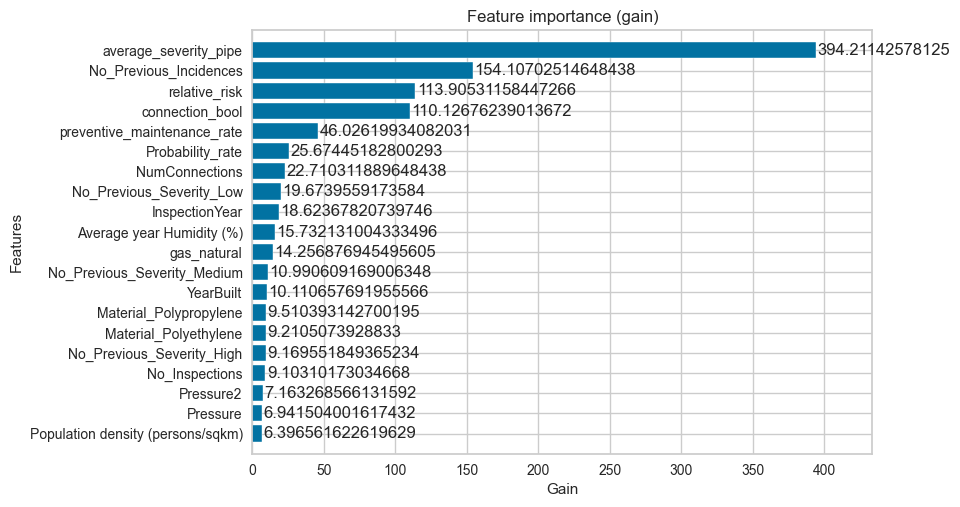

In [41]:
#predict on test data
y_pred = xgb_model.predict(X_test)

#accuracy score

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

#plot feature importance
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain', height=0.8, title='Feature importance (gain)', xlabel='Gain', ylabel='Features', grid=True, show_values=True)

Text(0, 0.5, 'AUC')

Text(0.5, 1.0, 'XGBoost AUC')

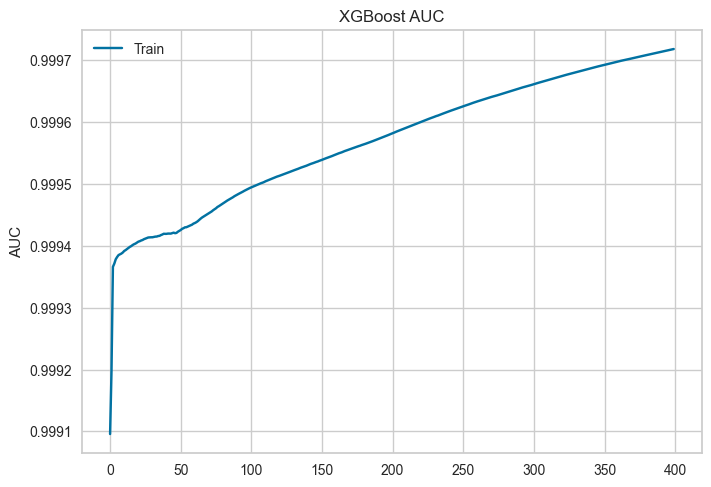

In [42]:
#plot training and validation AUC
results = xgb_model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()


In [43]:
#predict on test set
y_pred = xgb_model.predict(X_test)

#predict on train set
y_pred_train = xgb_model.predict(X)

#accuracy score on train set
accuracy_score(y, y_pred_train)

#accuracy score on test set
accuracy_score(y_test, y_pred)

#confusion matrix on train set
confusion_matrix(y, y_pred_train)

#confusion matrix on test set
confusion_matrix(y_test, y_pred)

#classification report on train set
print(classification_report(y, y_pred_train))

0.9990821092162351

0.997831231800979

array([[6330415,    1152],
       [   4671,    7654]], dtype=int64)

array([[907760,    204],
       [  1769,      0]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6331567
           1       0.87      0.62      0.72     12325

    accuracy                           1.00   6343892
   macro avg       0.93      0.81      0.86   6343892
weighted avg       1.00      1.00      1.00   6343892



In [44]:
#drop incidence in sample_submission
sample_submission = sample_submission.drop('Incidence', axis=1)

In [45]:
#make predictions for submission using the model
predictions = xgb_model.predict_proba(sample_submission)
predictions = predictions[:, 1]

In [46]:
#add predictions to submission
sample_submission ['Incidence'] = predictions

#show submission
sample_submission.head(1)

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,area_connection,connection_bool,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Diameter2,Length2,Pressure2,Average yearly temperature (°C),Min. Temperature (°C),Max. Temperature (°C),Yearly Rainfall (mm),Average year Humidity (%),Rainy days per year (days),Yearly Sun Hours (hours),No_Inspections,average_severity_pipe,Average_MonthsLastRev,pipe_inspected_frequently,No_Previous_Incidences,No_Previous_Severity_High,No_Previous_Severity_Medium,No_Previous_Severity_Low,InspectionYear,MonthsLastRev,relative_risk,preventive_maintenance_rate,Probability_rate,Age_pipe_at_inspection,Population density (persons/sqkm),Incidence
0,446859944,0.82,0.17,0.01,0.00,0.00,0.00,0,0.00,0.03,0.00,0.00,0,1,0,0,0,1,0,0.03,0.00,0.00,0.86,0.77,0.64,0.15,0.38,0.20,0.83,0.36,1.00,0.21,1.00,0.00,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.00,0.17,0.28,0.00


In [47]:
#drop all columns except PipeId and Incidence in submission2 creating kaggle_submission
kaggle_submission = sample_submission.drop(['YearBuilt', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle', 'aspect',
       'Relative_Thickness', 'pipe_area',
       'area_connection', 'connection_bool', 'gas_natural',
       'Material_Acrylonitrile-Butadiene-Styrene', 'Material_Copper',
       'Material_Fiberglass-Reinforced Plastic', 'Material_Polyethylene',
       'Material_Polypropylene', 'Diameter2', 'Length2', 'Pressure2',
       'Average yearly temperature (°C)', 'Min. Temperature (°C)',
       'Max. Temperature (°C)', 'Yearly Rainfall (mm)',
       'Average year Humidity (%)', 'Rainy days per year (days)',
       'Yearly Sun Hours (hours)', 'No_Inspections', 'average_severity_pipe',
       'Average_MonthsLastRev', 'pipe_inspected_frequently',
       'No_Previous_Incidences', 'No_Previous_Severity_High',
       'No_Previous_Severity_Medium', 'No_Previous_Severity_Low',
       'InspectionYear', 'MonthsLastRev', 'relative_risk',
       'preventive_maintenance_rate', 'Probability_rate',
       'Age_pipe_at_inspection','Population density (persons/sqkm)'], axis=1)


<Figure size 1000x1000 with 0 Axes>

<AxesSubplot: xlabel='Incidence'>

Text(0.5, 1.0, 'Incidence distribution in kaggle_submission')

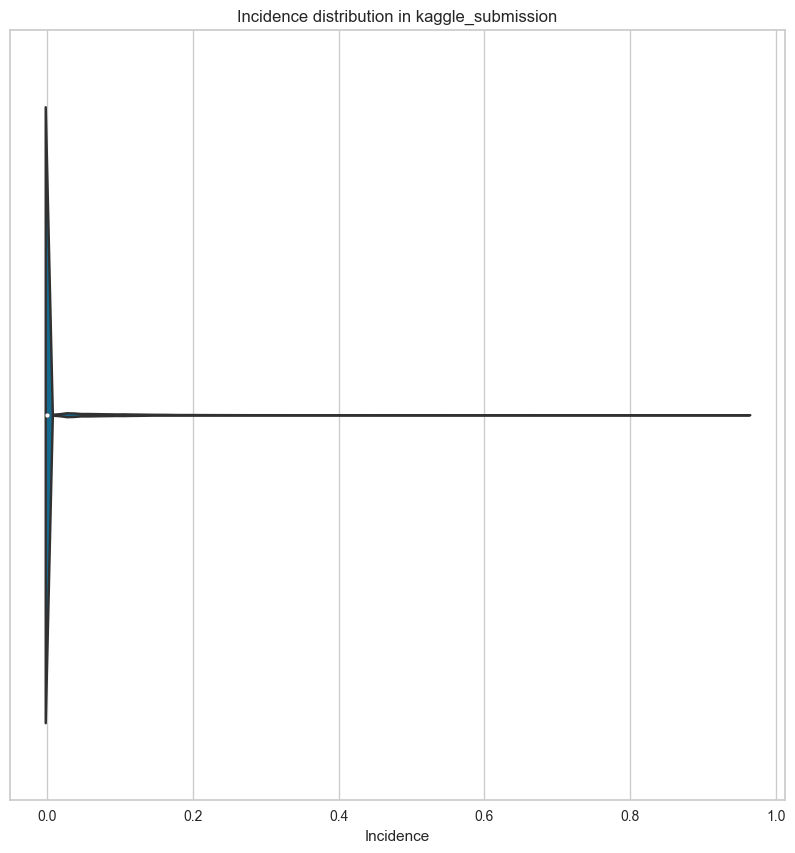

In [48]:
#plot violin plot of Incidence in kaggle_submission
plt.figure(figsize=(10, 10))
sns.violinplot(x='Incidence', data=kaggle_submission)
plt.title('Incidence distribution in kaggle_submission')
plt.show()


In [49]:
#show possible values for Incidence in kaggle_submission
kaggle_submission['Incidence'].value_counts()


0.00    276
0.00     94
0.00     74
0.00     72
0.00     61
       ... 
0.00      1
0.00      1
0.00      1
0.00      1
0.00      1
Name: Incidence, Length: 750805, dtype: int64

In [50]:
kaggle_submission.value_counts()

PipeId     Incidence
489780     0.00         1
222691572  0.00         1
222678889  0.00         1
222681822  0.00         1
222684960  0.00         1
                       ..
133579475  0.00         1
133579482  0.00         1
133579488  0.00         1
133579495  0.00         1
451995309  0.00         1
Length: 909733, dtype: int64

In [51]:
#show kaggle_submission
kaggle_submission.head(10)

,PipeId,Incidence
0,446859944,0.00
1,428124500,0.00
2,438428871,0.00
3,429034569,0.00
4,411184477,0.00
5,428837983,0.00
6,428837841,0.00
7,428838331,0.00
8,1200432,0.00
9,1200564,0.00


In [52]:
kaggle_submission.shape

(909733, 2)

In [53]:
#export kaggle_submission to csv
os.chdir(r"C:\Users\pedro\datathon")

kaggle_submission.to_csv('kaggle_submission_xgb_6_400_1.csv', index=False)

In [ ]:
#implement early stopping
eval_set = [(X, y)]     
xgb_model.fit(X, y, early_stopping_rounds=20,  verbose=True)


•	eta - [0.1, ]
•	gamma - [10^-3, 10^-1]
•	max_depth - [10, 50]
•	min_child_weight - [3, 10]
•	subsample - [0.5, 1]
•	colsample_bytree - [0.1, 1]
•	num_parallel_tree - [1, 100]

In a second layer of importance, I would include these two extra hyperparameters_

•	lambda - [0, 10] 
•	alpha - [0, 10]

In [ ]:
#print best ntree limit
print("Best ntree limit: ", xgb_model.best_ntree_limit)


In [ ]:


#predict on test set
y_pred = xgb_model.predict(X_test)

#predict on train set
y_pred_train = xgb_model.predict(X)

#accuracy score on train set
accuracy_score(y, y_pred_train)

#accuracy score on test set
accuracy_score(y_test, y_pred)

#confusion matrix on train set
confusion_matrix(y, y_pred_train)

#confusion matrix on test set
confusion_matrix(y_test, y_pred)

#classification report on train set
print(classification_report(y, y_pred_train))

#classification report on test set
print(classification_report(y_test, y_pred))

#plot feature importance
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain', height=0.5, grid=False, show_values=False, color='blue')



In [ ]:
xgb_model.fit(X, y)
y_pred = xgb_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))



In [ ]:
Hi guys,


Here is the list of hyperparameter to tune and an example of minimum and maximum values to test:




# Trying a model that overfits

In [ ]:
#rfc and cross validation using GridSearchCV to find best parameters and validate with a validation set with InspectionYear 2018 and 2019
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=2, class_weight='balanced_subsample', n_estimators=400, max_features='auto', max_depth=8, criterion='gini', min_samples_split=1, min_samples_leaf=1)


In [ ]:
#import StratifiedKFold
from sklearn.model_selection import StratifiedKFold


In [ ]:
#cross validation
cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=42)

In [ ]:
#use stratified kfold to split the data into train and validation sets
for train_index, val_index in cv.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#fit the model
rfc.fit(X_train, y_train)

#predict on validation set
y_pred = rfc.predict(X_val)

#check accuracy score
accuracy_score(y_val, y_pred)


In [ ]:
#for Diana's model

In [ ]:
#gridsearchcv
grid = GridSearchCV(estimator=rfc, cv=cv, scoring='roc_auc', verbose=2, n_jobs=-1)
grid.fit(X, y)

#best parameters
grid.best_params_

#best score
grid.best_score_

#best estimator
grid.best_estimator_

#predict on test set
y_pred = grid.predict(X_test)


In [ ]:
rfc.fit(X, y)
y_pred = rfc.predict(X_test)

In [ ]:
#use model to predict on test set
predictions = rfc.predict_proba(X_test)
predictions = predictions[:, 1]

#show accuracy score
print(accuracy_score(y_test, y_pred))

In [ ]:
#drop incidence in sample_submission
sample_submission = sample_submission.drop('Incidence', axis=1)

In [ ]:
#make predictions for submission using the model
predictions = rfc.predict_proba(sample_submission)
predictions = predictions[:, 1]

In [ ]:
#add predictions to submission
sample_submission ['Incidence'] = predictions

#show submission
sample_submission.head(1)

In [ ]:
#drop all columns except PipeId and Incidence in submission2 creating kaggle_submission
kaggle_submission = sample_submission.drop(['YearBuilt', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle', 'aspect',
       'Relative_Thickness', 'pipe_area',
       'area_connection', 'connection_bool', 'gas_natural',
       'Material_Acrylonitrile-Butadiene-Styrene', 'Material_Copper',
       'Material_Fiberglass-Reinforced Plastic', 'Material_Polyethylene',
       'Material_Polypropylene', 'Diameter2', 'Length2', 'Pressure2',
       'Average yearly temperature (°C)', 'Min. Temperature (°C)',
       'Max. Temperature (°C)', 'Yearly Rainfall (mm)',
       'Average year Humidity (%)', 'Rainy days per year (days)',
       'Yearly Sun Hours (hours)', 'No_Inspections', 'average_severity_pipe',
       'Average_MonthsLastRev', 'pipe_inspected_frequently',
       'No_Previous_Incidences', 'No_Previous_Severity_High',
       'No_Previous_Severity_Medium', 'No_Previous_Severity_Low',
       'InspectionYear', 'MonthsLastRev', 'relative_risk',
       'preventive_maintenance_rate', 'Probability_rate',
       'Age_pipe_at_inspection','Population density (persons/sqkm)'], axis=1)


In [ ]:
#show kaggle_submission
kaggle_submission.head(10)

In [ ]:
kaggle_submission.shape

In [ ]:
#export kaggle_submission to csv
os.chdir(r"C:\Users\pedro\datathon")

kaggle_submission.to_csv('kaggle_submission_rf8_400_minsampleleaf.csv', index=False)

In [ ]:
#random forest classifier with regularization and gridsearch to find the best parameters for the model
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth = 2, verbose=1, n_estimators=100, max_features='auto', min_samples_leaf=1, min_samples_split=2, class_weight='balanced' )
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predictions = rfc.predict_proba(X_test)
predictions = predictions[:, 1]

#show accuracy score
print(accuracy_score(y_test, y_pred))


In [ ]:
#show classification report
print(classification_report(y_test, y_pred))

In [ ]:
#use model to predict on test set
predictions = rfc.predict_proba(X_test)
predictions = predictions[:, 1]

#show accuracy score
print(accuracy_score(y_test, y_pred))

In [ ]:
#count null in sample_submission
sample_submission.isnull().sum()

In [ ]:
sample_submission.head(10)

In [ ]:
sample_submission.shape

In [ ]:
#drop incidence in sample_submission
sample_submission = sample_submission.drop('Incidence', axis=1)

In [ ]:
#make predictions for submission using the model
predictions = rfc.predict_proba(sample_submission)
predictions = predictions[:, 1]

In [ ]:
#add predictions to submission
sample_submission ['Incidence'] = predictions

#show submission
sample_submission.head(1)


In [ ]:
sample_submission.columns

In [ ]:
#drop all columns except PipeId and Incidence in submission2 creating kaggle_submission
kaggle_submission = sample_submission.drop(['Diameter', 'Length', 'Pressure', 'NumConnections', 'aspect',
       'Relative_Thickness', 'area_connection', 'gas_natural',
       'Material_Acrylonitrile-Butadiene-Styrene', 'Material_Copper',
       'Material_Fiberglass-Reinforced Plastic', 'Material_Polyethylene',
       'Material_Polypropylene', 'Yearly Sun Hours (hours)',
       'Average_MonthsLastRev', 'MonthsLastRev', 'No_Inspections',
       'No_Incidences_Total', 'Age_pipe_at_inspection',
       'Population density (persons/sqkm)'], axis=1)


In [ ]:

#show kaggle_submission
kaggle_submission.head(10)


In [ ]:
kaggle_submission.shape

In [ ]:
#export kaggle_submission to csv
os.chdir(r"C:\Users\pedro\datathon")

kaggle_submission.to_csv('kaggle_submission_new_features_baseline.csv', index=False)


# Lazypredict

In [ ]:
#using lazypredict to  find the best model to predict on the dataset
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric=None, predictions=True, random_state=42, n_jobs=-1)
models, predictions = clf.fit(X_train, X_train, X_test, y_test)
models
